STOCK PRICES MODEL v1.0

Flow of Notebook -

1. Data Preprocessing

2. Feature Extraction,

3. Feature Selection,

4. Model Testing/Training

5. Model Evaluation

In [ ]:
!pip install yfinance pandas numpy matplotlib seaborn scikit-learn tensorflow

In [ ]:
import yfinance as yf

# Define the stock symbol and date range
symbol = "AAPL"  # Example: Apple Inc.
start_date = "2010-01-01"
end_date = "2023-12-31"

# Fetch the data
df = yf.download(symbol, start=start_date, end=end_date)
df.head()
df.describe()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
count,3522.000000,3522.000000,3522.000000,3522.000000,3522.000000,3.522000e+03
mean,59.883701,60.528731,59.267621,59.926226,57.768186,2.422834e+08
std,55.387520,56.014467,54.812449,55.444533,55.706710,2.204578e+08
min,6.870357,7.000000,6.794643,6.858929,5.798900,2.404830e+07
25%,19.680447,19.832321,19.402321,19.608571,17.005858,9.266760e+07
50%,32.303749,32.633751,32.078751,32.340000,29.137095,1.526602e+08
75%,91.213125,92.512501,90.425623,91.207499,89.074623,3.284715e+08
max,198.020004,199.619995,197.000000,198.110001,197.589523,1.880998e+09


In [ ]:
# Drop any rows with missing values
df.dropna(inplace=True)

# Remove outliers using Interquartile Range (IQR) method
Q1 = df['Close'].quantile(0.25)
Q3 = df['Close'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['Close'] < (Q1 - 1.5 * IQR)) | (df['Close'] > (Q3 + 1.5 * IQR)))]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['Normalized_Close'] = scaler.fit_transform(df[['Close']])

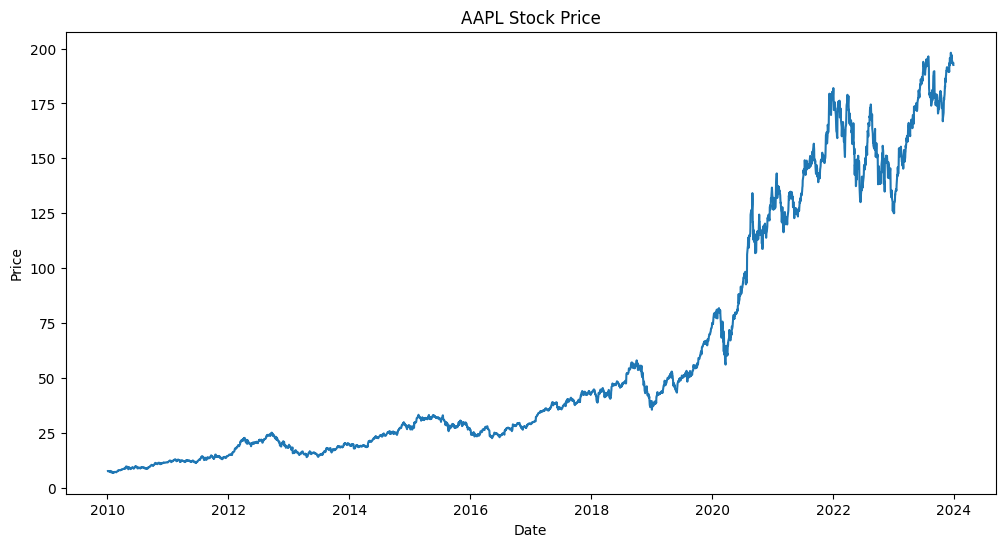

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'])
plt.title(f"{symbol} Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [ ]:
# Create lagged features
df['Lag_1'] = df['Close'].shift(1)
df['Lag_2'] = df['Close'].shift(2)

# Create simple moving average
df['SMA_5'] = df['Close'].rolling(window=5).mean()
df['SMA_20'] = df['Close'].rolling(window=20).mean()

# Create Relative Strength Index (RSI)
def calculate_rsi(data, periods=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = calculate_rsi(df['Close'])

# Drop rows with NaN values created by lagged features
df.dropna(inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

# Prepare features and target
features = ['Lag_1', 'Lag_2', 'SMA_5', 'SMA_20', 'RSI']
X = df[features]
y = df['Normalized_Close']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Reshape input data for LSTM (samples, time steps, features)
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

# Make predictions
lstm_predictions = lstm_model.predict(X_test_lstm)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 28.6501 - val_loss: 1.0782
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7269 - val_loss: 0.0496
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1367 - val_loss: 0.0279
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0807 - val_loss: 0.0178
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0563 - val_loss: 0.0140
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0389 - val_loss: 0.0159
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0411 - val_loss: 0.0094
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0361 - val_loss: 0.0103
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0291 - val_loss: 0.0095
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0268 - val_loss: 0.0051
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0274 - val_loss: 0.0050
Epoch 12/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} Results:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}\n")

evaluate_model(y_test, lr_predictions, "Linear Regression")
evaluate_model(y_test, lstm_predictions, "LSTM")

Linear Regression Results:
MSE: 0.0001
RMSE: 0.0071
MAE: 0.0037

LSTM Results:
MSE: 0.0012
RMSE: 0.0341
MAE: 0.0214



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lstm_model.fit(X_train_lstm, y_train, epochs=200, batch_size=32, validation_split=0.1,
               callbacks=[early_stopping], verbose=1)

Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - val_loss: 0.0018
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - val_loss: 8.9064e-04
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - val_loss: 8.4090e-04
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0011
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0012
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - val_loss: 7.7595e-04
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - val_loss: 0.0013
Epoch 8/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0017
Epoch 9/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0019
Epoch 10/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - val_loss: 7.6150e-04
Epoch 11/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0017
Epoch 12/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

In [ ]:
import plotly.graph_objects as go

def plot_predictions(y_true, y_pred, model_name):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index[-len(y_true):], y=scaler.inverse_transform(y_true.values.reshape(-1, 1)).flatten(),
                             mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=df.index[-len(y_pred):], y=scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten(),
                             mode='lines', name=f'{model_name} Prediction'))
    fig.update_layout(title=f'{model_name} Predictions vs Actual', xaxis_title='Date', yaxis_title='Stock Price')
    fig.show()

plot_predictions(y_test, lr_predictions, "Linear Regression")
plot_predictions(y_test, lstm_predictions, "LSTM")